## Description

This file will contain the preprocessing of brain recordings comparing resting state behavior with tapping activity. 
It will take the following steps:

1. Prepare environment
2. Import data (1 participant at a time)
3. Clean data:
    1. Apply filtering (0.5 - 50Hz)
    2. Apply Notch
    3. Remove flatlined channels
    4. Mark noisy channels
    5. Perform ICA
    6. Remove components that correlated with EOG and ECG
    7. Remove muscle components (spiky activity in 20-50Hz frequency range)
    8. Interpolate noisy channels
4. Re-reference data
5. Store cleaned data for analysis

In [1]:
# Perform required imports
import os
import PyQt5
import mne
import matplotlib.pyplot as plt
import numpy as np
from mne.preprocessing import ICA
import sklearn
from mne.time_frequency import psd_array_welch
from sklearn.decomposition import PCA

%matplotlib qt


In [84]:
# Set the participant ID
participant_id = "P05"

# Construct the folder path
file = f'Combined Raw Data/combined_raw_{participant_id}.fif'

raw = mne.io.read_raw(file, preload=True)


Opening raw data file Combined Raw Data/combined_raw_P05.fif...


C:\Users\mijsters\AppData\Local\Temp\ipykernel_19072\2659090724.py:7: RuntimeWarning: This filename (Combined Raw Data/combined_raw_P05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(file, preload=True)


Isotrak not found
    Range : 86442 ... 4929327 =     86.442 ...  4929.327 secs
Ready.
Reading 0 ... 4842885  =      0.000 ...  4842.885 secs...


In [85]:
# Filter data to be within the 0.5 and 40 Hz frequency bands, outside is likely noise
raw.filter(l_freq=0.1, h_freq=40.0)  


Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


<Raw | combined_raw_P05.fif, 68 x 4842886 (4842.9 s), ~2.45 GiB, data loaded>

In [86]:
# Set ECG, EOG and Photodiode channels
raw.set_channel_types({
    'BIP3': 'dipole',  # Replace 'ECG' with the actual name of your ECG channel
    'BIP7': 'ecg',  # Replace 'EOG1' with the actual name of your EOG channel
    'BIP8': 'eog',    # Replace 'EMG' with the actual name of your EMG channel
    'BIP9': 'eog'    # Replace 'EMG' with the actual name of your EMG channel
})


C:\Users\mijsters\AppData\Local\Temp\ipykernel_19072\2067019438.py:2: RuntimeWarning: The unit for channel(s) BIP3 has changed from V to NA.
  raw.set_channel_types({


<Raw | combined_raw_P05.fif, 68 x 4842886 (4842.9 s), ~2.45 GiB, data loaded>

In [87]:
# Remove EOG channel, which was connected to cap, but was not used, same for M1 and M2
unused_channels = ['M1', 'M2'] # Build-in EOG channel in cap was not used
raw.drop_channels(unused_channels)


<Raw | combined_raw_P05.fif, 66 x 4842886 (4842.9 s), ~2.38 GiB, data loaded>

In [88]:
# Completely remove flatlined channels, before ICA 
raw.info['bads'] = []
non_eeg_channels = ['BIP3', 'BIP7', 'BIP8', 'BIP9']

# Identify flat-lined channels and mark them as bad
channel_std = np.std(raw.get_data(), axis=1)
flatlined_channels = [ch_name for ch_name, std in zip(raw.ch_names, channel_std) if std < 1e-6]
print(f"Flatlined channels: {flatlined_channels}")
raw.drop_channels(flatlined_channels)


Flatlined channels: ['O2']


<Raw | combined_raw_P05.fif, 65 x 4842886 (4842.9 s), ~2.35 GiB, data loaded>

In [91]:

# Identify noisy channels, mark them as bad, but don't drop them just yet
# Calculate peak-to-peak amplitude for each channel
channel_ranges = np.ptp(raw.get_data(), axis=1)
raw.info['bads'] = []
# Define a threshold for noisy channels (e.g., > 150 μV) ADJUST BASED ON # OF BADS
noisy_channels = [ch_name for ch_name, rng in zip(raw.ch_names, channel_ranges) if rng > 250e-6]
print(f"Noisy channels: {noisy_channels}")
raw.info['bads'].extend(noisy_channels)
raw.info['bads'] = [
    ch_name for ch_name in raw.info['bads']
    if ch_name not in non_eeg_channels
]# Mark them as bad
print(len(raw.info['bads']))
print(raw.info['bads'])


Noisy channels: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'T8', 'CP5', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FC4', 'C5', 'C6', 'FT7', 'FT8', 'TP7', 'BIP3', 'BIP7', 'BIP8', 'BIP9']
28
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'T8', 'CP5', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FC4', 'C5', 'C6', 'FT7', 'FT8', 'TP7']


In [92]:

# Drop specific channels before ICA
raw.drop_channels('Oz_1')

# Apply the 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Copy and filter for ICA (common practice: 1-40 Hz bandpass)
ica_raw = raw.copy()
ica_raw.filter(l_freq=1, h_freq=40.0)

# ===== PCA to determine # of ICA components =====
print("Running PCA to determine number of ICA components...")

# Get data from filtered raw (shape: channels x samples)
data = ica_raw.get_data()

# Transpose to samples x channels for PCA
data_T = data.T

# Fit PCA
pca = PCA()
pca.fit(data_T)

# Get cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components to explain 99% variance
n_components_99 = np.where(cumulative_variance >= 0.999)[0][0] + 1

if n_components_99 < 15:
    n_components_99 = 15

print(f"Using {n_components_99} ICA components (99.9% variance + 1)")

# ===== Run ICA =====
ica = ICA(n_components=n_components_99, random_state=42, max_iter=800)

# Fit the ICA model to the raw EEG data
ica.fit(ica_raw)

# Optional: Plot ICA components to inspect
#ica.plot_components()

# Optional: Save ICA solution
ica.save(f'ICA Data/ica_{participant_id}.fif', overwrite=True)

print("ICA finished and saved.")


Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Running PCA to determine number of ICA components...
Using 16 ICA components (99.9% variance + 1)
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 103.8s.
Writing ICA solution to c:\Users\mijsters\Documents\Experiments\Cognitive EBDM\EEG Pilot\EEG Data Analysis\ICA Data\ica_P05.fif...
ICA finished and saved.


C:\Users\mijsters\AppData\Local\Temp\ipykernel_19072\57684105.py:46: RuntimeWarning: This filename (ICA Data/ica_P05.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(f'ICA Data/ica_{participant_id}.fif', overwrite=True)


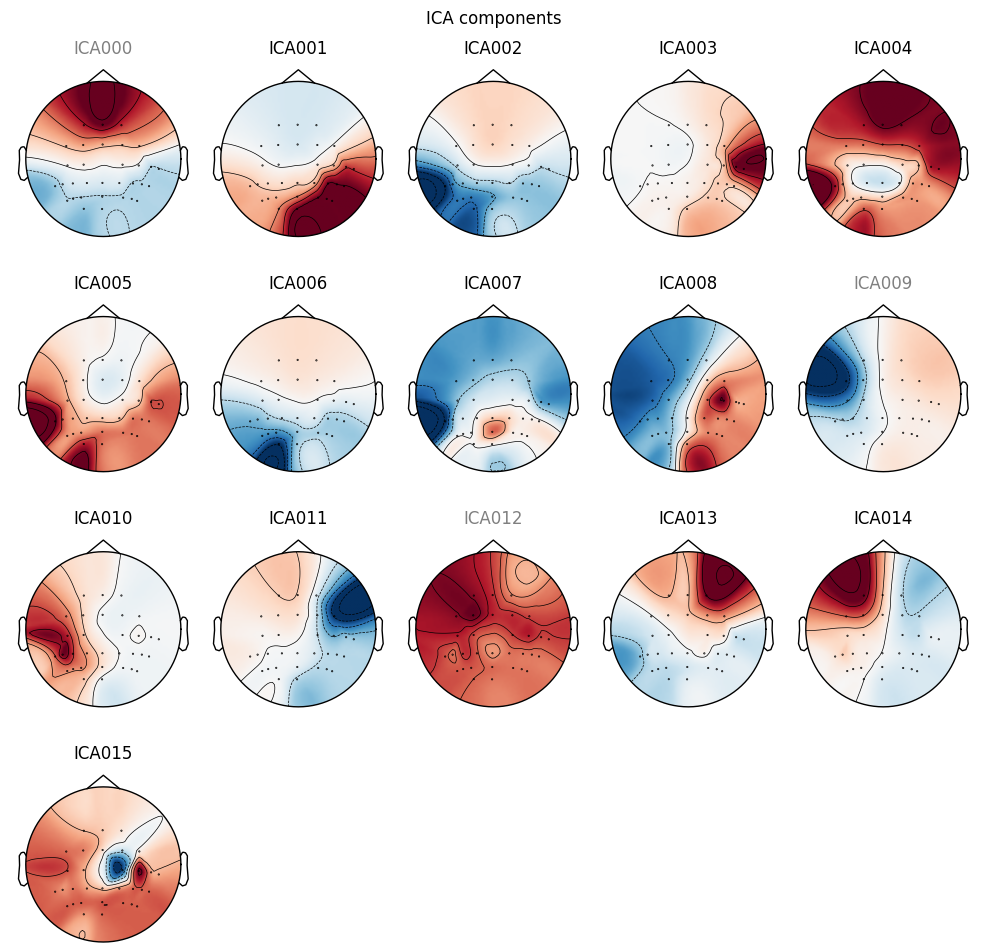

In [97]:
# Analyse ICA components that were found
ica.plot_components()  # Component index 10
# ica.plot_properties(ica_raw)


In [93]:
# Start removing EOG Components from the ICA, comparing to the EOG Channel

eog_indices, _ = ica.find_bads_eog(ica_raw)
print(f"Bad components identified: {eog_indices}")
ica.exclude = eog_indices


Using EOG channels: BIP8, BIP9
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.

In [94]:
# Remove ECG related components

ecg_indices, _ = ica.find_bads_ecg(ica_raw)
print(f"Bad ECG-related components: {ecg_indices}")
ica.exclude += ecg_indices


Using threshold: 0.16 for CTPS ECG detection
Using channel BIP7 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 6779 (average pulse 83.98711016530225 / min.)
Not setting metadata
6779 matching events found
No baseline correction applied
Using data from preloaded Raw for 6779 events and 1001 original time points ...
12 bad epochs dropped
Bad ECG-related components: []


In [95]:
# Visualize Power Spectrum of each component to identify muscle artifacts
# For muscle artifacts, find components that show spiky data in the high frequency band

# Calculate the power spectrum for each ICA component
n_components = ica.n_components_
for i in range(n_components):
    # Get the ICA component signals
    component_data = ica.get_sources(ica_raw).get_data(picks=[i])[0]
    # Compute the power spectrum
    psd, freqs = psd_array_welch(component_data, sfreq=raw.info['sfreq'], fmin=1, fmax=50, n_fft=2048)

    # Plot the power spectrum
    plt.figure(figsize=(6, 4))
    plt.plot(freqs, psd)
    plt.title(f'Power Spectrum of ICA Component {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.show()

    # Identify components with high frequency (>20 Hz) peaks for muscle activity


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


In [98]:
# Apply ICA exclusions to the data (so after identifying EOG, ECG and Muscle Artifacts)
# We will call this new dataset resting_state_clean

clean = raw.copy()
ica.apply(clean)



Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


<Raw | combined_raw_P05.fif, 64 x 4842886 (4842.9 s), ~2.31 GiB, data loaded>

In [99]:
# Interpolate bad channels

# If there are bad channels, interpolate them
clean.interpolate_bads()  # This will interpolate the marked bad channels

# Verify the interpolation was done
clean.info['bads']  # Check if there are still bad channels


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 32 sensor positions
Interpolating 28 sensors


[]

In [100]:
# Now we rereference the data to the average of the EEG electrodes

# Apply the average reference to the cleaned resting state data
clean.set_eeg_reference('average', projection=False)
# Check the new reference information
print(clean.info)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 60 EEG, 1 Dipole, 1 ECG, 2 EOG
 custom_ref_applied: True
 dig: 63 items (3 Cardinal, 60 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-02-14 14:56:07 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>


(64, 4842886)


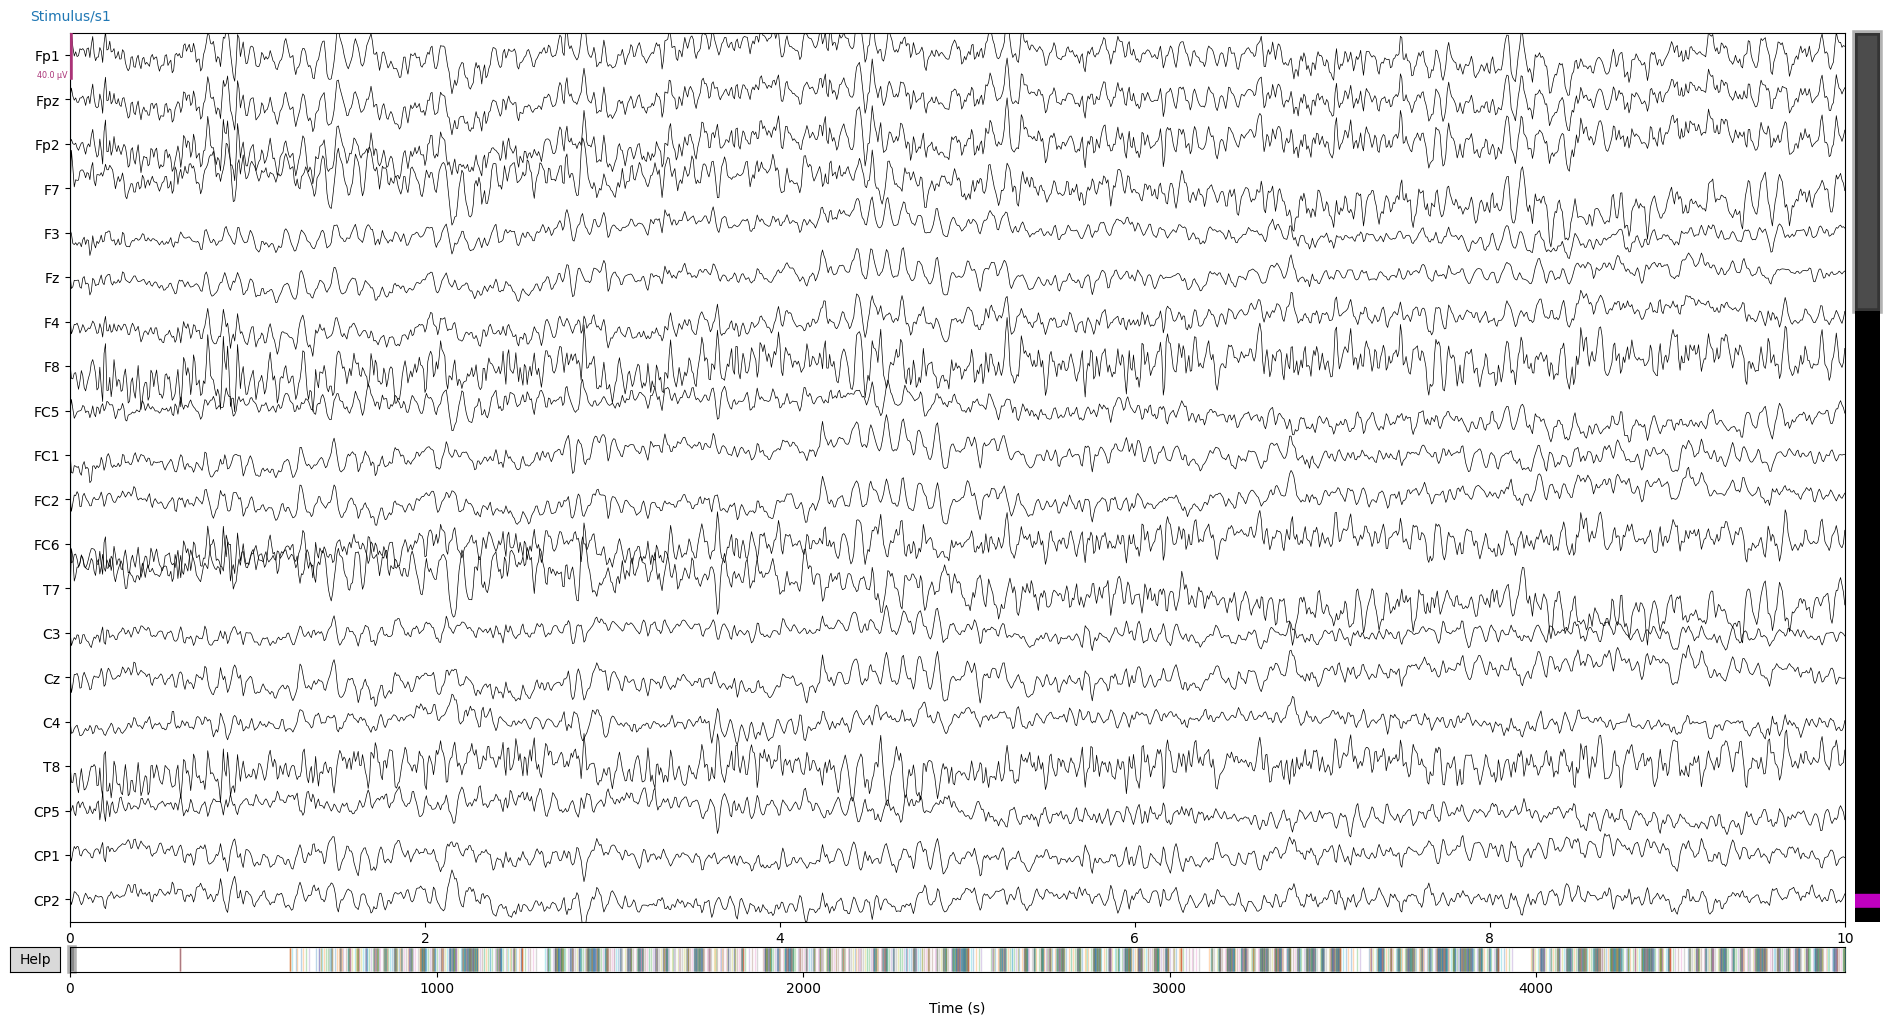

In [101]:
# Plot Resting State Cleaned
print(clean.get_data().shape)

clean.plot(duration=10, title='Cleaned Recording')




In [102]:
clean.save(f'Cleaned EEG Data/cleaned_EEG_{participant_id}.fif', overwrite=True)


Writing c:\Users\mijsters\Documents\Experiments\Cognitive EBDM\EEG Pilot\EEG Data Analysis\Cleaned EEG Data\cleaned_EEG_P05.fif


C:\Users\mijsters\AppData\Local\Temp\ipykernel_19072\4196209689.py:1: RuntimeWarning: This filename (c:\Users\mijsters\Documents\Experiments\Cognitive EBDM\EEG Pilot\EEG Data Analysis\Cleaned EEG Data\cleaned_EEG_P05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  clean.save(f'Cleaned EEG Data/cleaned_EEG_{participant_id}.fif', overwrite=True)


Closing c:\Users\mijsters\Documents\Experiments\Cognitive EBDM\EEG Pilot\EEG Data Analysis\Cleaned EEG Data\cleaned_EEG_P05.fif
[done]


[WindowsPath('c:/Users/mijsters/Documents/Experiments/Cognitive EBDM/EEG Pilot/EEG Data Analysis/Cleaned EEG Data/cleaned_EEG_P05.fif')]

Channels marked as bad:
none
